In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange

In [2]:
filename = 'data/ThumbPW_0022.gcsv'

with open(filename, 'r') as f:
    lines = f.readlines()
    gscale = float(lines[13].split(',')[1])
    print("gscale",gscale)
    ascale = float(lines[14].split(',')[1])
    print("ascale",ascale)
    del lines

# Lire le fichier CSV avec des paramètres supplémentaires
df = pd.read_csv(filename, sep=',', header=15) # , usecols=['col1', 'col2', 'col3','col4','col5','col6','col7']

# Afficher les premières lignes du DataFrame
print(df.head())

gscale 0.00053263221
ascale 0.00048828125
   t  rx  ry  rz   ax    ay   az
0  0 -34  13  27 -264 -2022 -284
1  1 -36  11  30 -265 -2023 -284
2  2 -36  11  25 -266 -2023 -285
3  3 -36  13  27 -265 -2023 -285
4  4 -36  11  29 -266 -2022 -283


In [3]:
g = 9.803244095066889

def updateXdot(x, t, u):
    xdot = np.zeros(10, dtype=np.float64)
    xdot[0] = (1 - 2 * (x[7]**2 + x[8]**2)) * u[0] + 2 * (x[6]*x[7] - x[8]*x[9]) * u[1] + 2 * (x[6]*x[8] + x[7]*x[9]) * u[2]
    xdot[1] = 2 * (x[6]*x[7] + x[8]*x[9]) * u[0] + (1 - 2 * (x[6]**2 + x[8]**2)) * u[1] + 2 * (x[7]*x[8] - x[6]*x[9]) * u[2]
    xdot[2] = 2 * (x[6]*x[8] - x[7]*x[9]) * u[0] + 2 * (x[7]*x[8] + x[6]*x[9]) * u[1] + (1 - 2 * (x[6]**2 + x[7]**2)) * u[2] - g
    xdot[3] = x[0]
    xdot[4] = x[1]
    xdot[5] = x[2]
    xdot[6] = 0.5*(u[3]*x[9] - u[4]*x[8] + u[5]*x[7])
    xdot[7] = 0.5*(u[3]*x[8] + u[4]*x[9] - u[5]*x[6])
    xdot[8] = 0.5*(-u[3]*x[7] + u[4]*x[6] + u[5]*x[9])
    xdot[9] = 0.5*(-u[3]*x[6] - u[4]*x[7] - u[5]*x[8])
    return xdot

def rotMatrixToQuat(M):
    # Takes a rotation matrix as input and returns a quaternion [qi, qj, qk, qw]
    T = M[0][0] + M[1][1] + M[2][2]  # Trace of M
    # Determine the maximum between the trace and the diagonal coefficients to ensure numerical stability
    temp1 = max(M[0][0], M[1][1])
    temp2 = max(M[2][2], T)
    m = max(temp1, temp2)
    qmax = 0.5 * np.sqrt(1 - T + 2 * m)
    if m == M[0][0]:
        q = np.array([qmax,
                (M[0][1] + M[1][0]) / (4 * qmax),
                (M[0][2] + M[2][0]) / (4 * qmax),
                (M[2][1] - M[1][2]) / (4 * qmax)], dtype=np.float64)
    elif m == M[1][1]:
        q = np.array([(M[0][1] + M[1][0]) / (4 * qmax),
                qmax,
                (M[1][2] + M[2][1]) / (4 * qmax),
                (M[0][2] - M[2][0]) / (4 * qmax)], dtype=np.float64)
    elif m == M[2][2]:
        q = np.array([(M[0][2] + M[2][0]) / (4 * qmax),
                (M[1][2] + M[2][1]) / (4 * qmax),
                qmax,
                (M[1][0] - M[0][1]) / (4 * qmax)], dtype=np.float64)
    else:
        q = np.array([(M[2][1] - M[1][2]) / (4 * qmax),
                (M[0][2] - M[2][0]) / (4 * qmax),
                (M[1][0] - M[0][1]) / (4 * qmax),
                qmax], dtype=np.float64)
    return q/np.linalg.norm(q)

# qs is a np.array of quaternions
def calculateTheta(qs):
    return np.pi/2-np.arccos(1.0 - 2.0 * (qs[:,0]*qs[:,0] + qs[:,1]*qs[:,1]))

def calculateAlpha(qs):
    return np.arctan2(-qs[:,0]*qs[:,2] - qs[:,1]*qs[:,3],-qs[:,0]*qs[:,3] + qs[:,1]*qs[:,2])

In [4]:
# alpha0 = 0.0 * np.pi / 180.0
alpha0 = 157 * np.pi / 180.0

t = np.array(df['t'], dtype=np.float64)/1000.0

# on retourne les axes de la camera pour que z soit vers le haut
# il faut aussi inverser les axes x et y pour que x soit vers la droite et y vers le bas
u = np.array(df[['az','ax','ay','rz','rx','ry']], dtype=np.float64)
u[:,0] *= -1
u[:,1] *= 1
u[:,2] *= -1
u[:,3] *= -1
u[:,4] *= 1
u[:,5] *= -1

t_static = 20 # temps qu'on utilise pour calculer l'accélération et le gyro moyens au sol
t_static_id = np.argmin(np.abs(t-t_static)) 

u0 = np.mean(u[:t_static_id], axis=0)

normAcc0 = np.linalg.norm(u0[0:3])
biasGyr0 = np.mean(u[:t_static_id], axis=0)[3:6]

u[:,3:6] = (u[:,3:6] - biasGyr0) * gscale
u[:,0:3] = u[:,0:3]*g/normAcc0 # pas besoin de ascale, on utilise juste g

## Calcul du quaternion initial
U = u0[0:3]/normAcc0
U = U/ np.linalg.norm(U) # comme ça on est super sûr que U est un vecteur unitaire

tN = np.cross(U, np.array([1,0,0], dtype=np.float64))
tN /= np.linalg.norm(tN)
N = tN.copy() # c'est temporaire, on va calucler la matrice et tourner seulement après pour coincider avec le bon azimuth

E = np.cross(N, U)
E = E/np.linalg.norm(E)

M0 = np.array([E,N,U]) # = (E N U).T
q0 = rotMatrixToQuat(M0)
alpha_init_temporaire = np.arctan2(-2*q0[0]*q0[2] - 2*q0[1]*q0[3], -2*q0[0]*q0[3] + 2*q0[1]*q0[2])

beta =  alpha0 - alpha_init_temporaire
rotM = np.array([[np.cos(beta), -np.sin(beta), 0],
                [np.sin(beta), np.cos(beta), 0],
                [0, 0, 1]])

M0 = (M0.T @ rotM.T).T # on tourne autour de U pour que l'azimuth soit bon
q0 = rotMatrixToQuat(M0)

# on peut verifier l'azimuth :
alpha_init = np.arctan2(-2*q0[0]*q0[2] - 2*q0[1]*q0[3], -2*q0[0]*q0[3] + 2*q0[1]*q0[2])
print("alpha_init",alpha_init*180/np.pi)

# on peut aussi verifier qu'on peut reobtenir M0 à partir de q0
M_test = np.array([
        [1 - 2*(q0[1]**2 + q0[2]**2), 2*(q0[0]*q0[1] - q0[3]*q0[2]), 2*(q0[0]*q0[2] + q0[3]*q0[1])],
        [2*(q0[0]*q0[1] + q0[3]*q0[2]), 1 - 2*(q0[0]**2 + q0[2]**2), 2*(q0[1]*q0[2] - q0[3]*q0[0])],
        [2*(q0[0]*q0[2] - q0[3]*q0[1]), 2*(q0[1]*q0[2] + q0[3]*q0[0]), 1 - 2*(q0[0]**2 + q0[1]**2)]
    ])

print("M_test-M0",M_test-M0)

alpha_init 156.99999999999997
M_test-M0 [[-1.66533454e-16  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.11022302e-16]]


In [5]:
file_name_suffix = "before_parachute"
# file_name_suffix = "full"

In [6]:
# setup de l'integration

x0 = np.array([0,0,0, 0,0,0, q0[0], q0[1], q0[2], q0[3]], dtype=np.float64)
decollage=44.242 # selon les données
dec = 0 # selon ce qu'on veut dans les courbes
para = 57.063 - decollage
print(para)
t0 = decollage - 1 # début de l'integration
# fin de l'integration
if file_name_suffix == "full":
    tf = decollage+60 # fin du vol
else:
    tf = decollage+15 # un peu après le parachute
id_t0 = np.argmin(np.abs(t-t0))
id_tf = np.argmin(np.abs(t-tf))
print("id_t0",id_t0)
print("id_tf",id_tf)

x = np.zeros((len(t),10), dtype=np.float64)
x[id_t0,:] = x0

12.821000000000005
id_t0 43242
id_tf 59242


In [7]:
# integration d'euler
# for i in trange(id_t0+1,id_tf+1):
#         x[i,:] = x[i-1,:] + (t[i]-t[i-1])*updateXdot(x[i-1,:], t[i], u[i,:])


# 4th order runge kutta (meilleur que l'integration d'euler)
for i in trange(id_t0+1,id_tf+1):
        k1 = updateXdot(x[i-1,:], t[i-1], u[i-1,:])
        k2 = updateXdot(x[i-1,:]+0.5*k1*(t[i]-t[i-1]), t[i-1]+0.5*(t[i]-t[i-1]), u[i-1,:])
        k3 = updateXdot(x[i-1,:]+0.5*k2*(t[i]-t[i-1]), t[i-1]+0.5*(t[i]-t[i-1]), u[i-1,:])
        k4 = updateXdot(x[i-1,:]+k3*(t[i]-t[i-1]), t[i-1]+(t[i]-t[i-1]), u[i-1,:])
        x[i,:] = x[i-1,:] + (t[i]-t[i-1])/6*(k1+2*k2+2*k3+k4)

100%|██████████| 16000/16000 [00:00<00:00, 17349.83it/s]


In [8]:
# export des données
# save x and t in the same pickle file
import pickle
with open('x.pkl', 'wb') as f:
    pickle.dump(x, f)
    pickle.dump(t, f)

# import
# with open('x.pkl', 'rb') as f:
#     x = pickle.load(f)
#     t = pickle.load(f)


In [9]:
# calcul des valeurs interressantes :

# assiette de l'axe de la fuséee
theta = np.pi/2-np.arccos(1.0 - 2.0 * (x[:,6]*x[:,6] + x[:,7]*x[:,7]))

# assiette du vecteur vitesse de la fusée
theta_v = np.pi/2 - np.arccos(x[:,2]/np.linalg.norm(x[:,:3].T, axis=0))

# azimuth de la fusée
alpha = np.arctan2(-x[:,6]*x[:,8] - x[:,7]*x[:,9],-x[:,6]*x[:,9] + x[:,7]*x[:,8])

# azimuth du vecteur vitesse de la fusée
alpha_v = np.arctan2(-x[:, 0], x[:, 1])

# vecteur axe de la fusée
rocket_axis =  np.array([2 * (x[:,6]*x[:,8] - x[:,7]*x[:,9]),2 * (x[:,7]*x[:,8] + x[:,6]*x[:,9]),(1 - 2 * (x[:,6]**2 + x[:,7]**2))], dtype=np.float64).T

# vitesse selon l'axe de la fusée (v scalaire l'axe)
v_proj = x[:,0]*(2 * (x[:,6]*x[:,8] - x[:,7]*x[:,9]))+x[:,1]*(2 * (x[:,7]*x[:,8] + x[:,6]*x[:,9]))+x[:,2]*(1 - 2 * (x[:,6]**2 + x[:,7]**2))

# angle (absolue) entre l'axe de la fusée et le vecetur vitesse
derapage = np.arccos(np.clip((rocket_axis[:,0]*x[:,0]+rocket_axis[:,1]*x[:,1]+rocket_axis[:,2]*x[:,2])/np.linalg.norm(x[:,:3].T, axis=0), -1.0, 1.0))

# angle entre X et X0 selon Z
X = np.array([1 - 2 * (x[:,7]**2 + x[:,8]**2), 2 * (x[:,6]*x[:,7] - x[:,8]*x[:,9]), 2 * (x[:,6]*x[:,8] + x[:,7]*x[:,9])]).T
Z = np.array([2 * (x[:,6]*x[:,8] - x[:,7]*x[:,9]), 2 * (x[:,7]*x[:,8] + x[:,6]*x[:,9]), 1 - 2 * (x[:,6]**2 + x[:,7]**2)]).T
cross = np.cross(X[id_t0],X)
roulis = np.arctan2(cross[:,0]*Z[:,0]+cross[:,1]*Z[:,1]+cross[:,2]*Z[:,2],X[id_t0][0]*X[:,0]+X[id_t0][1]*X[:,1]+X[id_t0][2]*X[:,2])

from ambiance import Atmosphere
altitude_au_sol = 420 # en m
vnorm = np.linalg.norm(x[:,:3], axis=1) # en m/s
vmach = vnorm/Atmosphere(x[:,5] + altitude_au_sol).speed_of_sound # en mach

C:\Users\thoma\AppData\Local\Temp\ipykernel_5880\3972609937.py:7: RuntimeWarning: invalid value encountered in divide
  theta_v = np.pi/2 - np.arccos(x[:,2]/np.linalg.norm(x[:,:3].T, axis=0))
C:\Users\thoma\AppData\Local\Temp\ipykernel_5880\3972609937.py:22: RuntimeWarning: invalid value encountered in divide
  derapage = np.arccos(np.clip((rocket_axis[:,0]*x[:,0]+rocket_axis[:,1]*x[:,1]+rocket_axis[:,2]*x[:,2])/np.linalg.norm(x[:,:3].T, axis=0), -1.0, 1.0))


In [10]:
%matplotlib widget
# %matplotlib inline

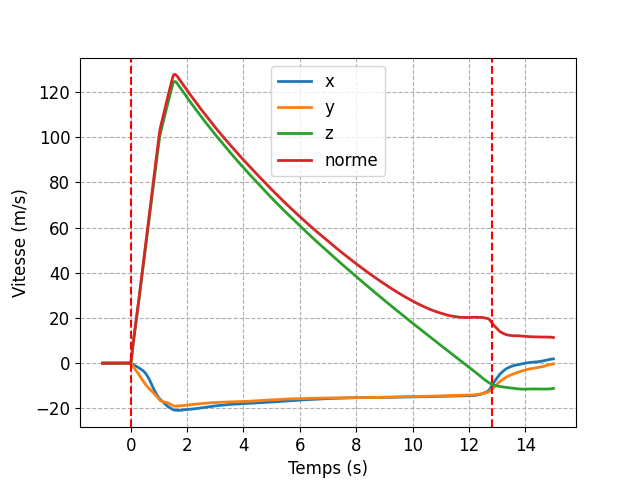

In [11]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, x[id_t0:id_tf][:,0:3],linewidth=2)
plt.plot(t[id_t0:id_tf]-decollage, vnorm[id_t0:id_tf],linewidth=2)
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)', size=12)
plt.ylabel('Vitesse (m/s)', size=12)
plt.legend(['x', 'y', 'z', 'norme'],fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.savefig(f"velocity_{file_name_suffix}.png")
plt.show()

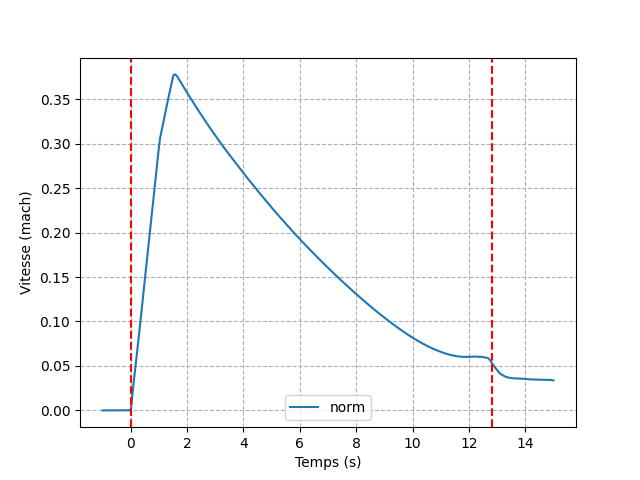

In [12]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, vmach[id_t0:id_tf])
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)')
plt.ylabel('Vitesse (mach)')
plt.legend(['norm'])
plt.grid(linestyle='--')
plt.savefig(f"mach_{file_name_suffix}.png")
plt.show()

In [13]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, x[id_t0:id_tf][:,3:6])
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend(['x', 'y', 'z'])
plt.grid(linestyle='--')
plt.savefig(f"position_{file_name_suffix}.png")
plt.show()

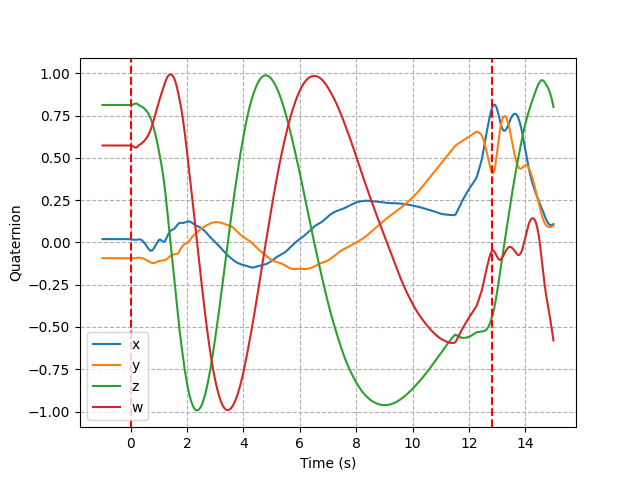

In [14]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, x[id_t0:id_tf][:,6:10])
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Quaternion')
plt.legend(['x', 'y', 'z', 'w'])
plt.grid(linestyle='--')
plt.savefig(f"quaternion_{file_name_suffix}.png")
plt.show()

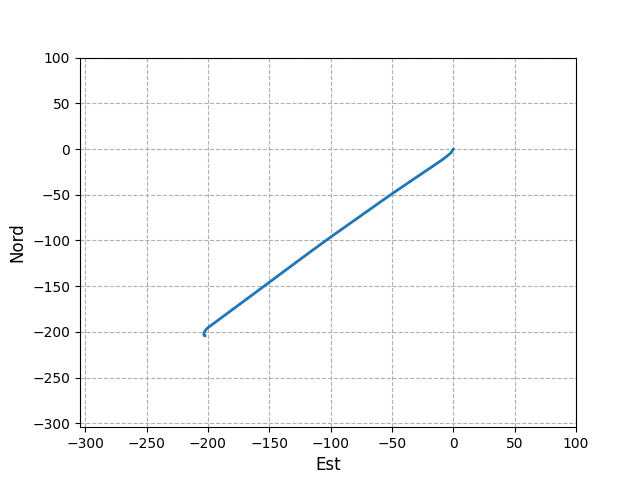

In [15]:
plt.figure()
plt.plot(x[id_t0:id_tf,3], x[id_t0:id_tf,4], linewidth=2)
plt.xlabel('Est', size=12)
plt.ylabel('Nord', size=12)
plt.xlim([min(min(x[id_t0:id_tf,3]),min(x[id_t0:id_tf,4]))-100, max(max(x[id_t0:id_tf,3]),max(x[id_t0:id_tf,4]))+100])
plt.ylim([min(min(x[id_t0:id_tf,3]),min(x[id_t0:id_tf,4]))-100, max(max(x[id_t0:id_tf,3]),max(x[id_t0:id_tf,4]))+100])
plt.grid(linestyle='--')
plt.savefig(f"trajectory_{file_name_suffix}.png")
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.show()

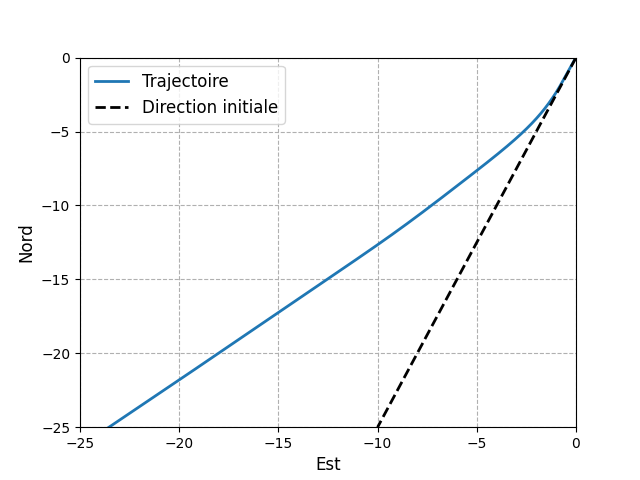

In [16]:
plt.figure()

plt.plot(x[id_t0:id_tf,3], x[id_t0:id_tf,4], linewidth=2)

direction_ini_x = np.linspace(0,-10,id_tf-id_t0)
direction_ini_y = np.linspace(0,-25,id_tf-id_t0)
plt.plot(direction_ini_x,direction_ini_y,linewidth=2,linestyle='--',color='black')

plt.xlabel('Est', size=12)
plt.ylabel('Nord', size=12)
plt.xlim([-25, 0])
plt.ylim([-25, 0])
plt.legend(['Trajectoire','Direction initiale'],fontsize=12)
plt.grid(linestyle='--')
plt.savefig(f"trajectory_deviation.png")
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.show()

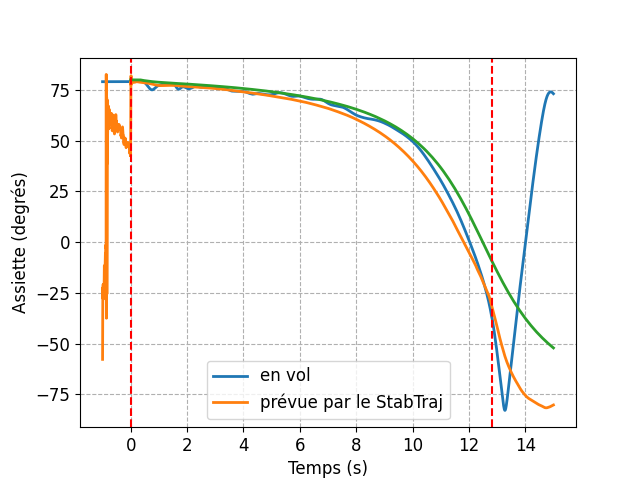

In [27]:
# Read the CSV file
df2 = pd.read_csv("assiette_stabtraj.csv",delimiter=';')

plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, theta[id_t0:id_tf]*180/np.pi, linewidth=2)
plt.plot(df2[(df2['t'] >= 0) & (df2['t'] <= 15)]['t'], df2[(df2['t'] >= 0) & (df2['t'] <= 15)]['Assiette'], linewidth=2)
# plt.plot(t[id_t0:id_tf]-decollage, theta_v[id_t0:id_tf]*180/np.pi, linewidth=2)
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)', size=12)
plt.ylabel('Assiette (degrés)',size=12)
plt.legend(['en vol','prévue par le StabTraj'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.savefig(f"assiette_{file_name_suffix}.png")
plt.show()

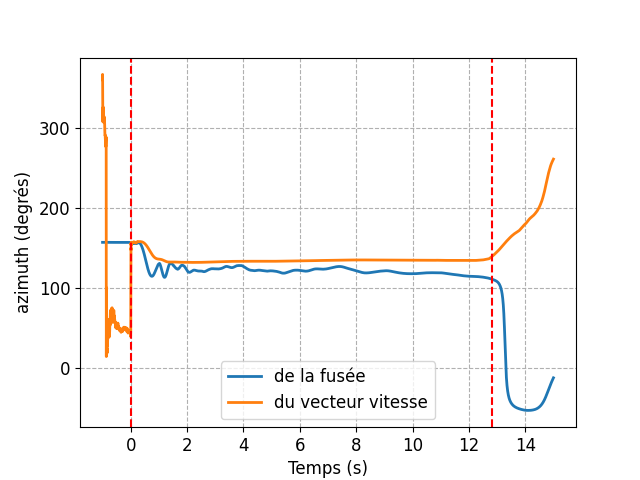

In [18]:
plt.figure()
# plt.plot(t[id_t0:id_tf]-decollage, (np.unwrap(alpha[id_t0:id_tf])-alpha0)*180/np.pi)
# plt.plot(t[id_t0:id_tf]-decollage, (np.unwrap(alpha_v[id_t0:id_tf])-alpha0)*180/np.pi+360)
plt.plot(t[id_t0:id_tf]-decollage, (np.unwrap(alpha[id_t0:id_tf]))*180/np.pi, linewidth=2)
plt.plot(t[id_t0:id_tf]-decollage, (np.unwrap(alpha_v[id_t0:id_tf]))*180/np.pi+360, linewidth=2)
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)', size=12)
plt.ylabel('azimuth (degrés)', size=12)
plt.legend(['de la fusée','du vecteur vitesse'],fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.savefig(f"azimuth_{file_name_suffix}.png")
plt.show()

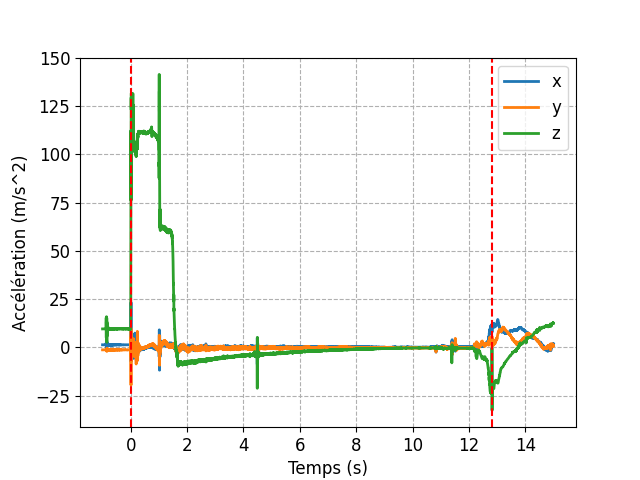

In [19]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, u[id_t0:id_tf,:3],linewidth=2)
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)', size=12)
plt.ylabel('Accélération (m/s^2)', size=12)
plt.legend(['x', 'y', 'z'],fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.savefig(f"acceleration_{file_name_suffix}.png")
plt.show()

45802


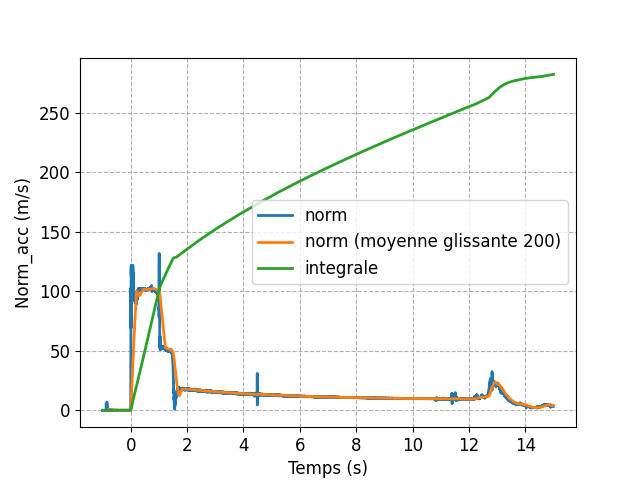

In [20]:
acc_fixe = np.zeros((len(t),3), dtype=np.float64)
for i in range(len(t)):
    acc_fixe[i,0] = (1 - 2 * (x[i,7]**2 + x[i,8]**2)) * u[i,0] + 2 * (x[i,6]*x[i,7] - x[i,8]*x[i,9]) * u[i,1] + 2 * (x[i,6]*x[i,8] + x[i,7]*x[i,9]) * u[i,2]
    acc_fixe[i,1] = 2 * (x[i,6]*x[i,7] + x[i,8]*x[i,9]) * u[i,0] + (1 - 2 * (x[i,6]**2 + x[i,8]**2)) * u[i,1] + 2 * (x[i,7]*x[i,8] - x[i,6]*x[i,9]) * u[i,2]
    acc_fixe[i,2] = 2 * (x[i,6]*x[i,8] - x[i,7]*x[i,9]) * u[i,0] + 2 * (x[i,7]*x[i,8] + x[i,6]*x[i,9]) * u[i,1] + (1 - 2 * (x[i,6]**2 + x[i,7]**2)) * u[i,2] - g


id_tprop = np.argmin(np.abs(t-1.56-decollage)) # temps de la poussée
print(id_tprop)
norm = np.linalg.norm(acc_fixe[id_t0:id_tf], axis=1)
integrale = [np.trapz(norm[:i], t[id_t0:id_t0+i]-decollage) for i in range(len(norm))]
# print("intégrale de l'accélération",integrale[id_tprop])


plt.figure()
window_size = 200
norm_smooth = pd.Series(norm).rolling(window_size).mean()

plt.plot(t[id_t0:id_tf]-decollage, norm,linewidth=2)
plt.plot(t[id_t0:id_tf]-decollage, norm_smooth,linewidth=2)
plt.plot(t[id_t0:id_tf]-decollage, integrale,linewidth=2)
plt.xlabel('Temps (s)', size=12)
plt.ylabel('Norm_acc (m/s)', size=12)
plt.legend(['norm',f'norm (moyenne glissante {window_size})','integrale'],fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')

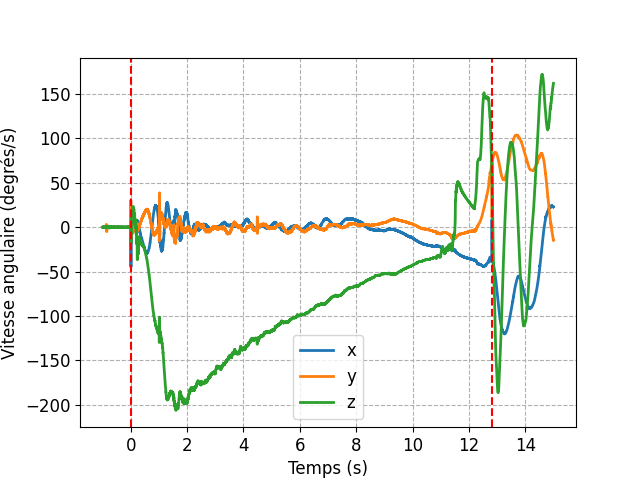

In [21]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, u[id_t0:id_tf,3:6]*180/np.pi,linewidth=2)
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)',size=12)
plt.ylabel('Vitesse angulaire (degrés/s)',size=12)
plt.legend(['x', 'y', 'z'],fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.savefig(f"gyro_{file_name_suffix}.png")
plt.show()

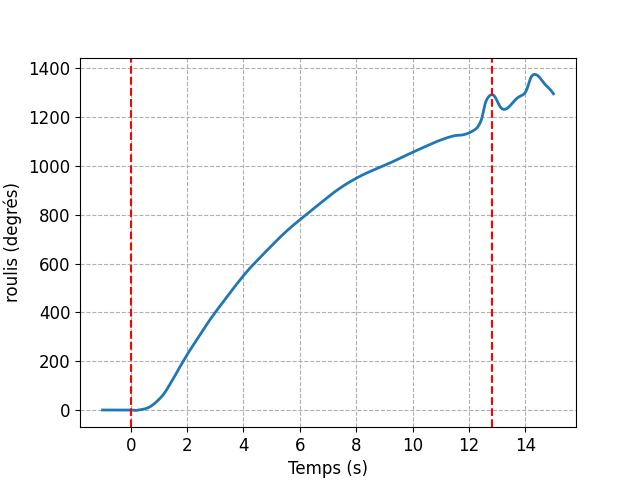

In [22]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, np.unwrap(roulis[id_t0:id_tf])*180/np.pi, linewidth=2)
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)', size=12)
plt.ylabel('roulis (degrés)', size=12)
# plt.legend(['phi'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.savefig(f"roulis_{file_name_suffix}.png")
plt.show()

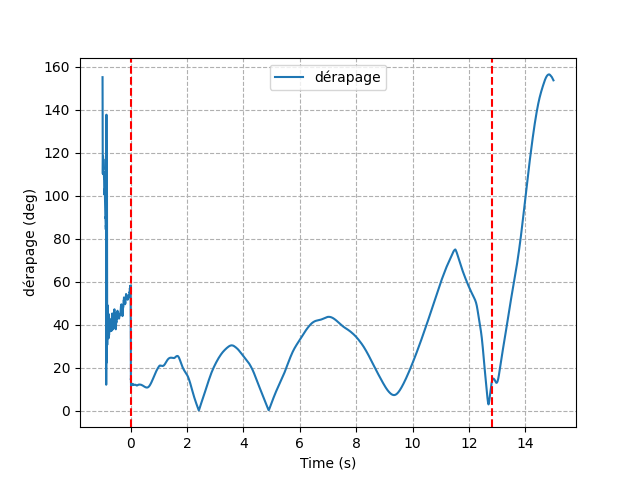

In [23]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, derapage[id_t0:id_tf]*180/np.pi)
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('dérapage (deg)')
plt.legend(['dérapage'])
plt.grid(linestyle='--')
plt.savefig(f"derapage_{file_name_suffix}.png")
plt.show()

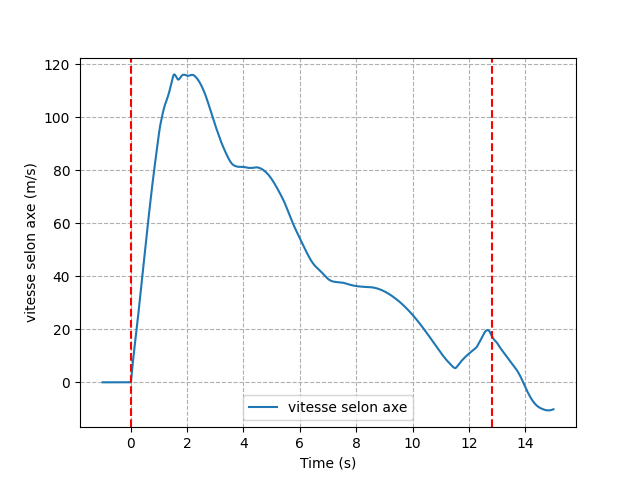

In [24]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, v_proj[id_t0:id_tf])
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('vitesse selon axe (m/s)')
plt.legend(['vitesse selon axe'])
plt.grid(linestyle='--')
plt.savefig(f"vitesse_axe_{file_name_suffix}.png")
plt.show()

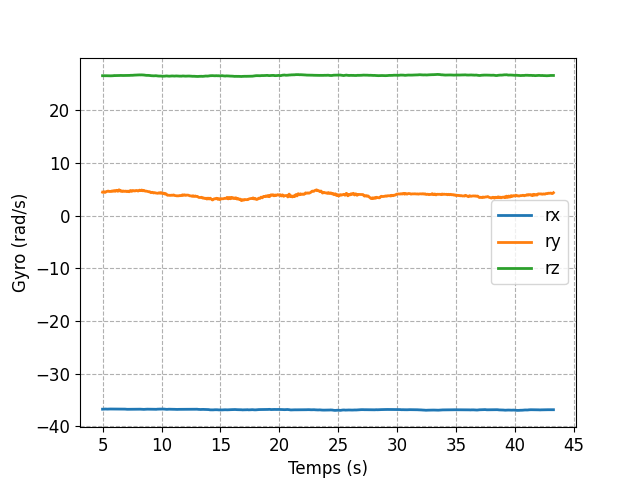

In [25]:
plt.figure()
window_size = 5000
rx_smooth = pd.Series(df['rx'][:id_t0]).rolling(window_size).mean()
ry_smooth = pd.Series(df['ry'][:id_t0]).rolling(window_size).mean()
rz_smooth = pd.Series(df['rz'][:id_t0]).rolling(window_size).mean()

plt.plot(df['t'][:id_t0]/1000, rx_smooth,linewidth=2)
plt.plot(df['t'][:id_t0]/1000, ry_smooth,linewidth=2)
plt.plot(df['t'][:id_t0]/1000, rz_smooth,linewidth=2)
plt.xlabel('Temps (s)', size=12)
plt.ylabel('Gyro (rad/s)', size=12)
plt.legend(['rx','ry','rz'],fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')

In [26]:
plt.figure()
window_size = 1000
ax_smooth = pd.Series(df['ax'][:id_t0]).rolling(window_size).mean()*g/normAcc0
ay_smooth = pd.Series(df['ay'][:id_t0]).rolling(window_size).mean()*g/normAcc0
az_smooth = pd.Series(df['az'][:id_t0]).rolling(window_size).mean()*g/normAcc0

plt.plot(df['t'][:id_t0]/1000, ax_smooth, linewidth=2)
plt.plot(df['t'][:id_t0]/1000, ay_smooth, linewidth=2)
plt.plot(df['t'][:id_t0]/1000, az_smooth, linewidth=2)
plt.xlabel('Temps (s)', size=12)
plt.ylabel(f'Accélération (m/s$^2$)', size=12)
plt.legend(['ax','ay','az'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')